## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.tree import export_graphviz
from IPython.display import Image  
import graphviz
from sklearn.metrics import accuracy_score
from six import StringIO
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from xgboost import XGBRegressor

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## PART 1

### a. Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

In [2]:
diagnosis_data = pd.read_csv('../data/diagnosis.csv',header=None)
diagnosis_data.columns = ['a1','a2','a3','a4','a5','a6','d1','d2']

In [3]:
#Backup 
diagnosis_data_copy = diagnosis_data.copy()

In [4]:
print(diagnosis_data.shape)
diagnosis_data.head()

(120, 8)


,a1,a2,a3,a4,a5,a6,d1,d2
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [5]:
diagnosis_data['a2'] = diagnosis_data.a2.map(dict(yes=1, no=0))
diagnosis_data['a3'] = diagnosis_data.a3.map(dict(yes=1, no=0))
diagnosis_data['a4'] = diagnosis_data.a4.map(dict(yes=1, no=0))
diagnosis_data['a5'] = diagnosis_data.a5.map(dict(yes=1, no=0))
diagnosis_data['a6'] = diagnosis_data.a6.map(dict(yes=1, no=0))
diagnosis_data['d1'] = diagnosis_data.d1.map(dict(yes=1, no=0))
diagnosis_data['d2'] = diagnosis_data.d2.map(dict(yes=1, no=0))

### b. Build a decision tree on the whole data set and plot it.

In [6]:
X = diagnosis_data[['a1','a2','a3','a4','a5','a6']]
y = diagnosis_data[['d1','d2']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(diagnosis_data.drop(['d1','d2'],axis=1), 
                                                    diagnosis_data[['d1','d2']],
                                                    test_size=0.2, random_state = 10)

In [8]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

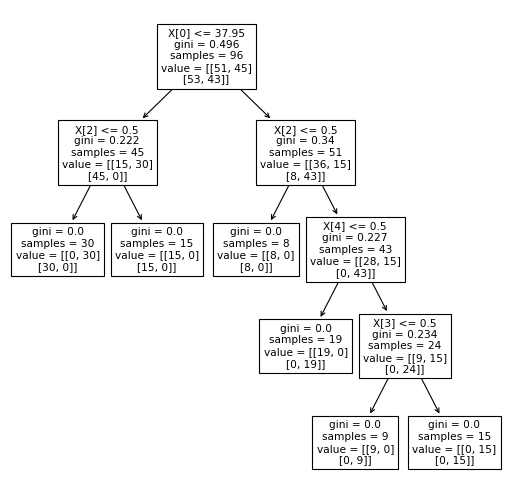

In [9]:
plt.figure(figsize=(8, 8), dpi=80)
tree.plot_tree(clf)
plt.show()

In [10]:
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)
print(f'The accuracy of predicted model is: {accuracy_score(y_test,pred_test)}')

The accuracy of predicted model is: 1.0


### c. Convert the decision rules into a set of IF-THEN rules.

In [11]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):

    '''
    Outputs a decision tree model as a Python function

    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as a function
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [12]:
tree_to_code(clf, list(diagnosis_data.columns))

def tree(a1, a2, a3, a4, a5, a6, d1, d2):
  if a1 <= 37.95000076293945:
    if a3 <= 0.5:
      return [[ 0. 30.]
 [30.  0.]]
    else:  # if a3 > 0.5
      return [[15.  0.]
 [15.  0.]]
  else:  # if a1 > 37.95000076293945
    if a3 <= 0.5:
      return [[8. 0.]
 [8. 0.]]
    else:  # if a3 > 0.5
      if a5 <= 0.5:
        return [[19.  0.]
 [ 0. 19.]]
      else:  # if a5 > 0.5
        if a4 <= 0.5:
          return [[9. 0.]
 [0. 9.]]
        else:  # if a4 > 0.5
          return [[ 0. 15.]
 [ 0. 15.]]


### d. Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [13]:
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 100)
clf_pruned.fit(X_train, y_train)

preds_pruned_Xtest = clf_pruned.predict(X_test)
preds_pruned_Xtrain = clf_pruned.predict(X_train)

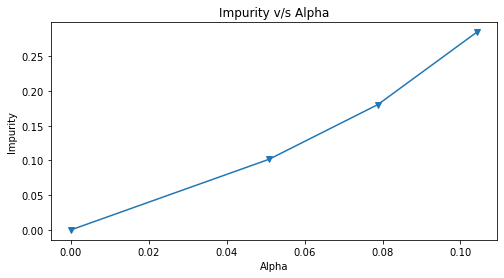

In [14]:
path = clf_pruned.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='v')

ax.set_title("Impurity v/s Alpha")
ax.set_xlabel("Alpha");
ax.set_ylabel("Impurity")
plt.show()

In [15]:
print('The best alpha is: 0.0')
print(f'The accuracy of predicted model is: {round(accuracy_score(y_test,preds_pruned_Xtest),2)}')

The best alpha is: 0.0
The accuracy of predicted model is: 1.0


In [16]:
idealAlpha = 0.0 

clf_pruned_best = DecisionTreeClassifier(criterion = "gini", random_state = 100, ccp_alpha=idealAlpha)
clf_pruned_best.fit(X_train, y_train)

best_pruned_Xtest = clf_pruned_best.predict(X_test)
best_pruned_Xtrain = clf_pruned_best.predict(X_train)
print(f'The accuracy of predicted model is: {accuracy_score(y_test,best_pruned_Xtest)}')

The accuracy of predicted model is: 1.0


In [17]:
tree_to_code(clf_pruned, list(diagnosis_data.columns))

def tree(a1, a2, a3, a4, a5, a6, d1, d2):
  if a1 <= 37.95000076293945:
    if a3 <= 0.5:
      return [[ 0. 30.]
 [30.  0.]]
    else:  # if a3 > 0.5
      return [[15.  0.]
 [15.  0.]]
  else:  # if a1 > 37.95000076293945
    if a3 <= 0.5:
      return [[8. 0.]
 [8. 0.]]
    else:  # if a3 > 0.5
      if a5 <= 0.5:
        return [[19.  0.]
 [ 0. 19.]]
      else:  # if a5 > 0.5
        if a4 <= 0.5:
          return [[9. 0.]
 [0. 9.]]
        else:  # if a4 > 0.5
          return [[ 0. 15.]
 [ 0. 15.]]


## PART 2

### a. Download the Communities and Crime data3 from https://archive.ics.uci. edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

### b. The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [31]:
# Importing the dataset
community_data = pd.read_csv("../data/communities.csv",header=None)

# Reading list of attributes from text file using regex
community_names = open('../data/communitiesnames.txt','r')
community_names = community_names.read()
colList = re.findall(r'-{2}\s(\w+)\:{1}',community_names)
colList = colList[2:]

#Adding column names to the dataset
community_data.columns = colList

print(community_data.shape)
community_data.head()

(1994, 128)


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [32]:
# Dropping non-predictive features
community_data.drop(columns=['state','county','community','communityname','fold'], axis=1, inplace=True)

#Converting all columns to float
community_data = community_data.replace({'?':None}) 
community_data = community_data.astype('float64')

# List of columns with null values 
null_cols = community_data.columns[community_data.isna().any()].tolist()

# Means of columns
community_means = community_data.mean()

# Replacing NAs with means
community_data.fillna(community_means,inplace=True)

In [33]:
# Train-test split

community_train = community_data.loc[0:1494]
community_test = community_data.loc[1495:]

print(community_train.shape)
print(community_test.shape)

(1495, 123)
(499, 123)


In [34]:
community_trainX = community_train.iloc[:,:-1]
community_trainY = community_train.iloc[:,-1]

community_testX = community_test.iloc[:,:-1]
community_testY = community_test.iloc[:,-1]

### c. Plot a correlation matrix for the features in the data set.

In [22]:
corrMat = community_train.corr()
corrMat

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
population,1.000000,-0.040404,0.242144,-0.306023,0.168868,0.162282,0.014554,0.128721,0.075744,-0.107060,...,0.747424,0.235510,0.283682,0.632908,0.605296,-0.025145,0.056257,0.464459,-0.026309,0.364245
householdsize,-0.040404,1.000000,-0.068374,-0.243565,0.209848,0.473320,0.517742,0.371658,0.301949,-0.606714,...,-0.020832,-0.003807,-0.030652,-0.015262,0.002494,-0.030790,0.006218,-0.086315,-0.018727,-0.031156
racepctblack,0.242144,-0.068374,1.000000,-0.793431,-0.104912,-0.069449,0.118272,0.143406,0.125330,0.056381,...,0.155017,0.101270,0.169002,0.143520,0.110430,-0.095939,0.029114,0.257781,0.035458,0.644094
racePctWhite,-0.306023,-0.243565,-0.793431,1.000000,-0.270829,-0.436737,-0.189135,-0.258390,-0.175195,0.138619,...,-0.147054,-0.339787,-0.234460,-0.132483,-0.133257,0.058860,-0.056293,-0.272366,-0.021934,-0.690614
racePctAsian,0.168868,0.209848,-0.104912,-0.270829,1.000000,0.264600,-0.017945,0.106958,0.056442,-0.283709,...,0.004790,0.360708,0.274826,-0.023221,0.047362,0.039235,0.053917,0.100653,-0.007105,0.034705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LemasPctPolicOnPatr,-0.025145,-0.030790,-0.095939,0.058860,0.039235,0.027440,-0.025836,-0.001793,-0.001886,0.019427,...,-0.041487,0.086089,0.046135,-0.118012,-0.068563,1.000000,-0.031897,0.089963,-0.188977,-0.024592
LemasGangUnitDeploy,0.056257,0.006218,0.029114,-0.056293,0.053917,0.052045,0.035347,0.019096,0.017357,-0.034982,...,0.081390,-0.064061,-0.077679,0.008921,-0.012981,-0.031897,1.000000,0.005617,-0.041395,0.085016
LemasPctOfficDrugUn,0.464459,-0.086315,0.257781,-0.272366,0.100653,0.126210,0.012529,0.117998,0.083582,-0.022575,...,0.322885,0.236545,0.209710,-0.054953,-0.047174,0.089963,0.005617,1.000000,-0.005498,0.331882
PolicBudgPerPop,-0.026309,-0.018727,0.035458,-0.021934,-0.007105,0.021495,-0.049715,-0.040955,-0.035223,0.043379,...,-0.116224,0.088812,0.098568,0.274865,0.296427,-0.188977,-0.041395,-0.005498,1.000000,0.069578


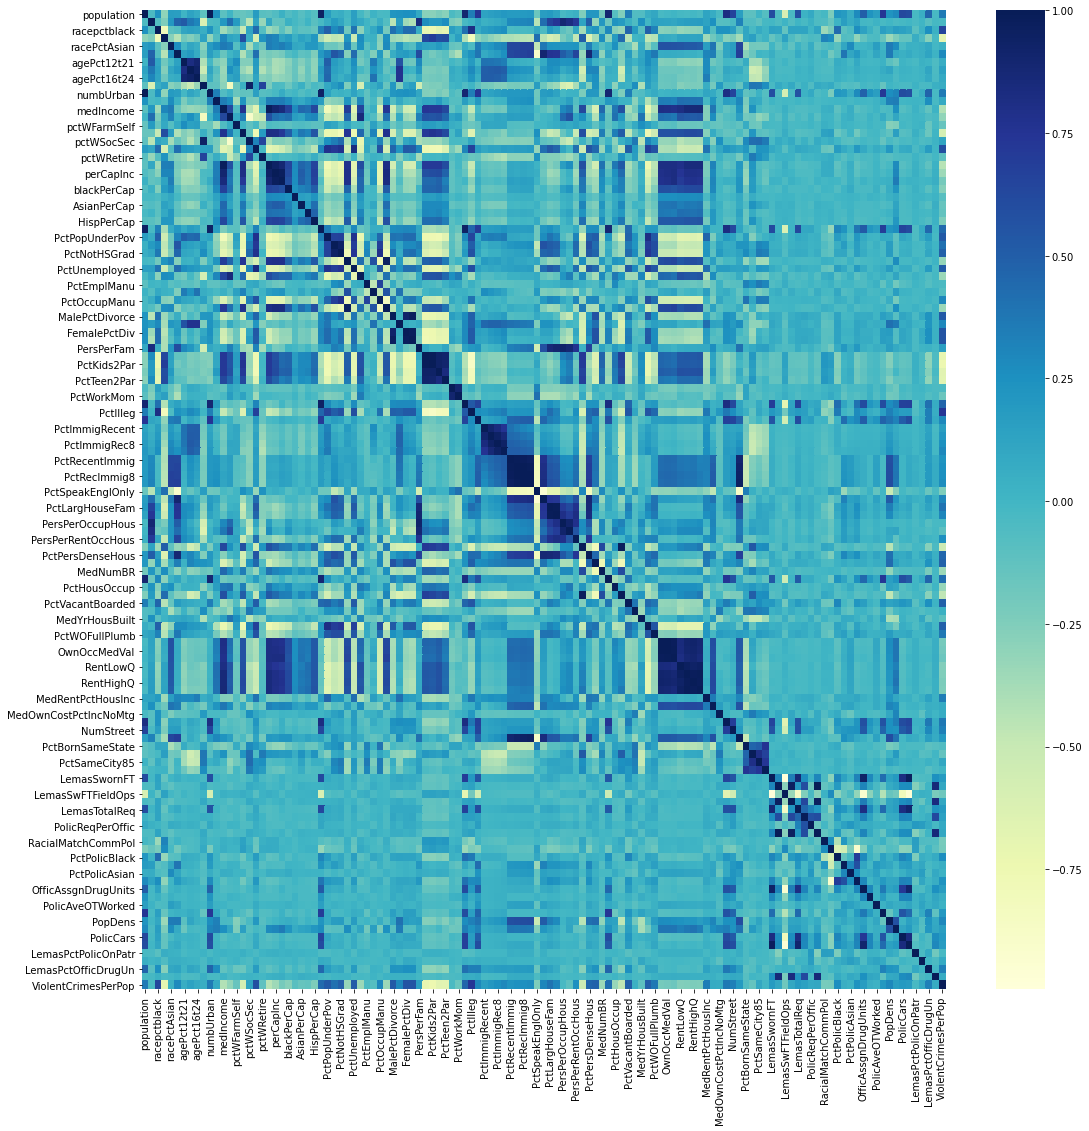

In [23]:
plt.figure(figsize=(18, 18))
sns.heatmap(corrMat,cmap="YlGnBu")
plt.show()

### d. Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean..

In [35]:
cv = lambda x:np.std(x, ddof=1)/np.mean(x)*100

pd.set_option('display.max_rows', 130)

print("Coefficient of Variance:")
cv_df = pd.DataFrame(community_train.apply(cv),columns=['Coefficient of Variance'])
cv_df

Coefficient of Variance:


,Coefficient of Variance
population,224.110462
householdsize,35.579957
racepctblack,142.888542
racePctWhite,33.021266
racePctAsian,135.909968
racePctHisp,161.209101
agePct12t21,36.908312
agePct12t29,29.131481
agePct16t24,50.030991
agePct65up,41.277598


In [36]:
pd.set_option('display.max_rows', 10)

### e. Pick √128 features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [25]:
print(np.sqrt(128))
print("Since sqrt of 128 is 11.3, picking 11 features with highest CV")

11.313708498984761
Since sqrt of 128 is 11.3, picking 11 features with highest CV


In [26]:
listCV = community_train.apply(cv)
top11CV = listCV.sort_values(ascending=False)[:11]
namesCV = list(top11CV.index)
top11CV_df = community_train[namesCV]

In [29]:
top11CV_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NumStreet            1495 non-null   float64
 1   NumInShelters        1495 non-null   float64
 2   NumIlleg             1495 non-null   float64
 3   NumImmig             1495 non-null   float64
 4   LemasPctOfficDrugUn  1495 non-null   float64
 5   NumUnderPov          1495 non-null   float64
 6   population           1495 non-null   float64
 7   numbUrban            1495 non-null   float64
 8   HousVacant           1495 non-null   float64
 9   LandArea             1495 non-null   float64
 10  racePctHisp          1495 non-null   float64
dtypes: float64(11)
memory usage: 128.6 KB


In [27]:
type(top11CV_df)

pandas.core.frame.DataFrame

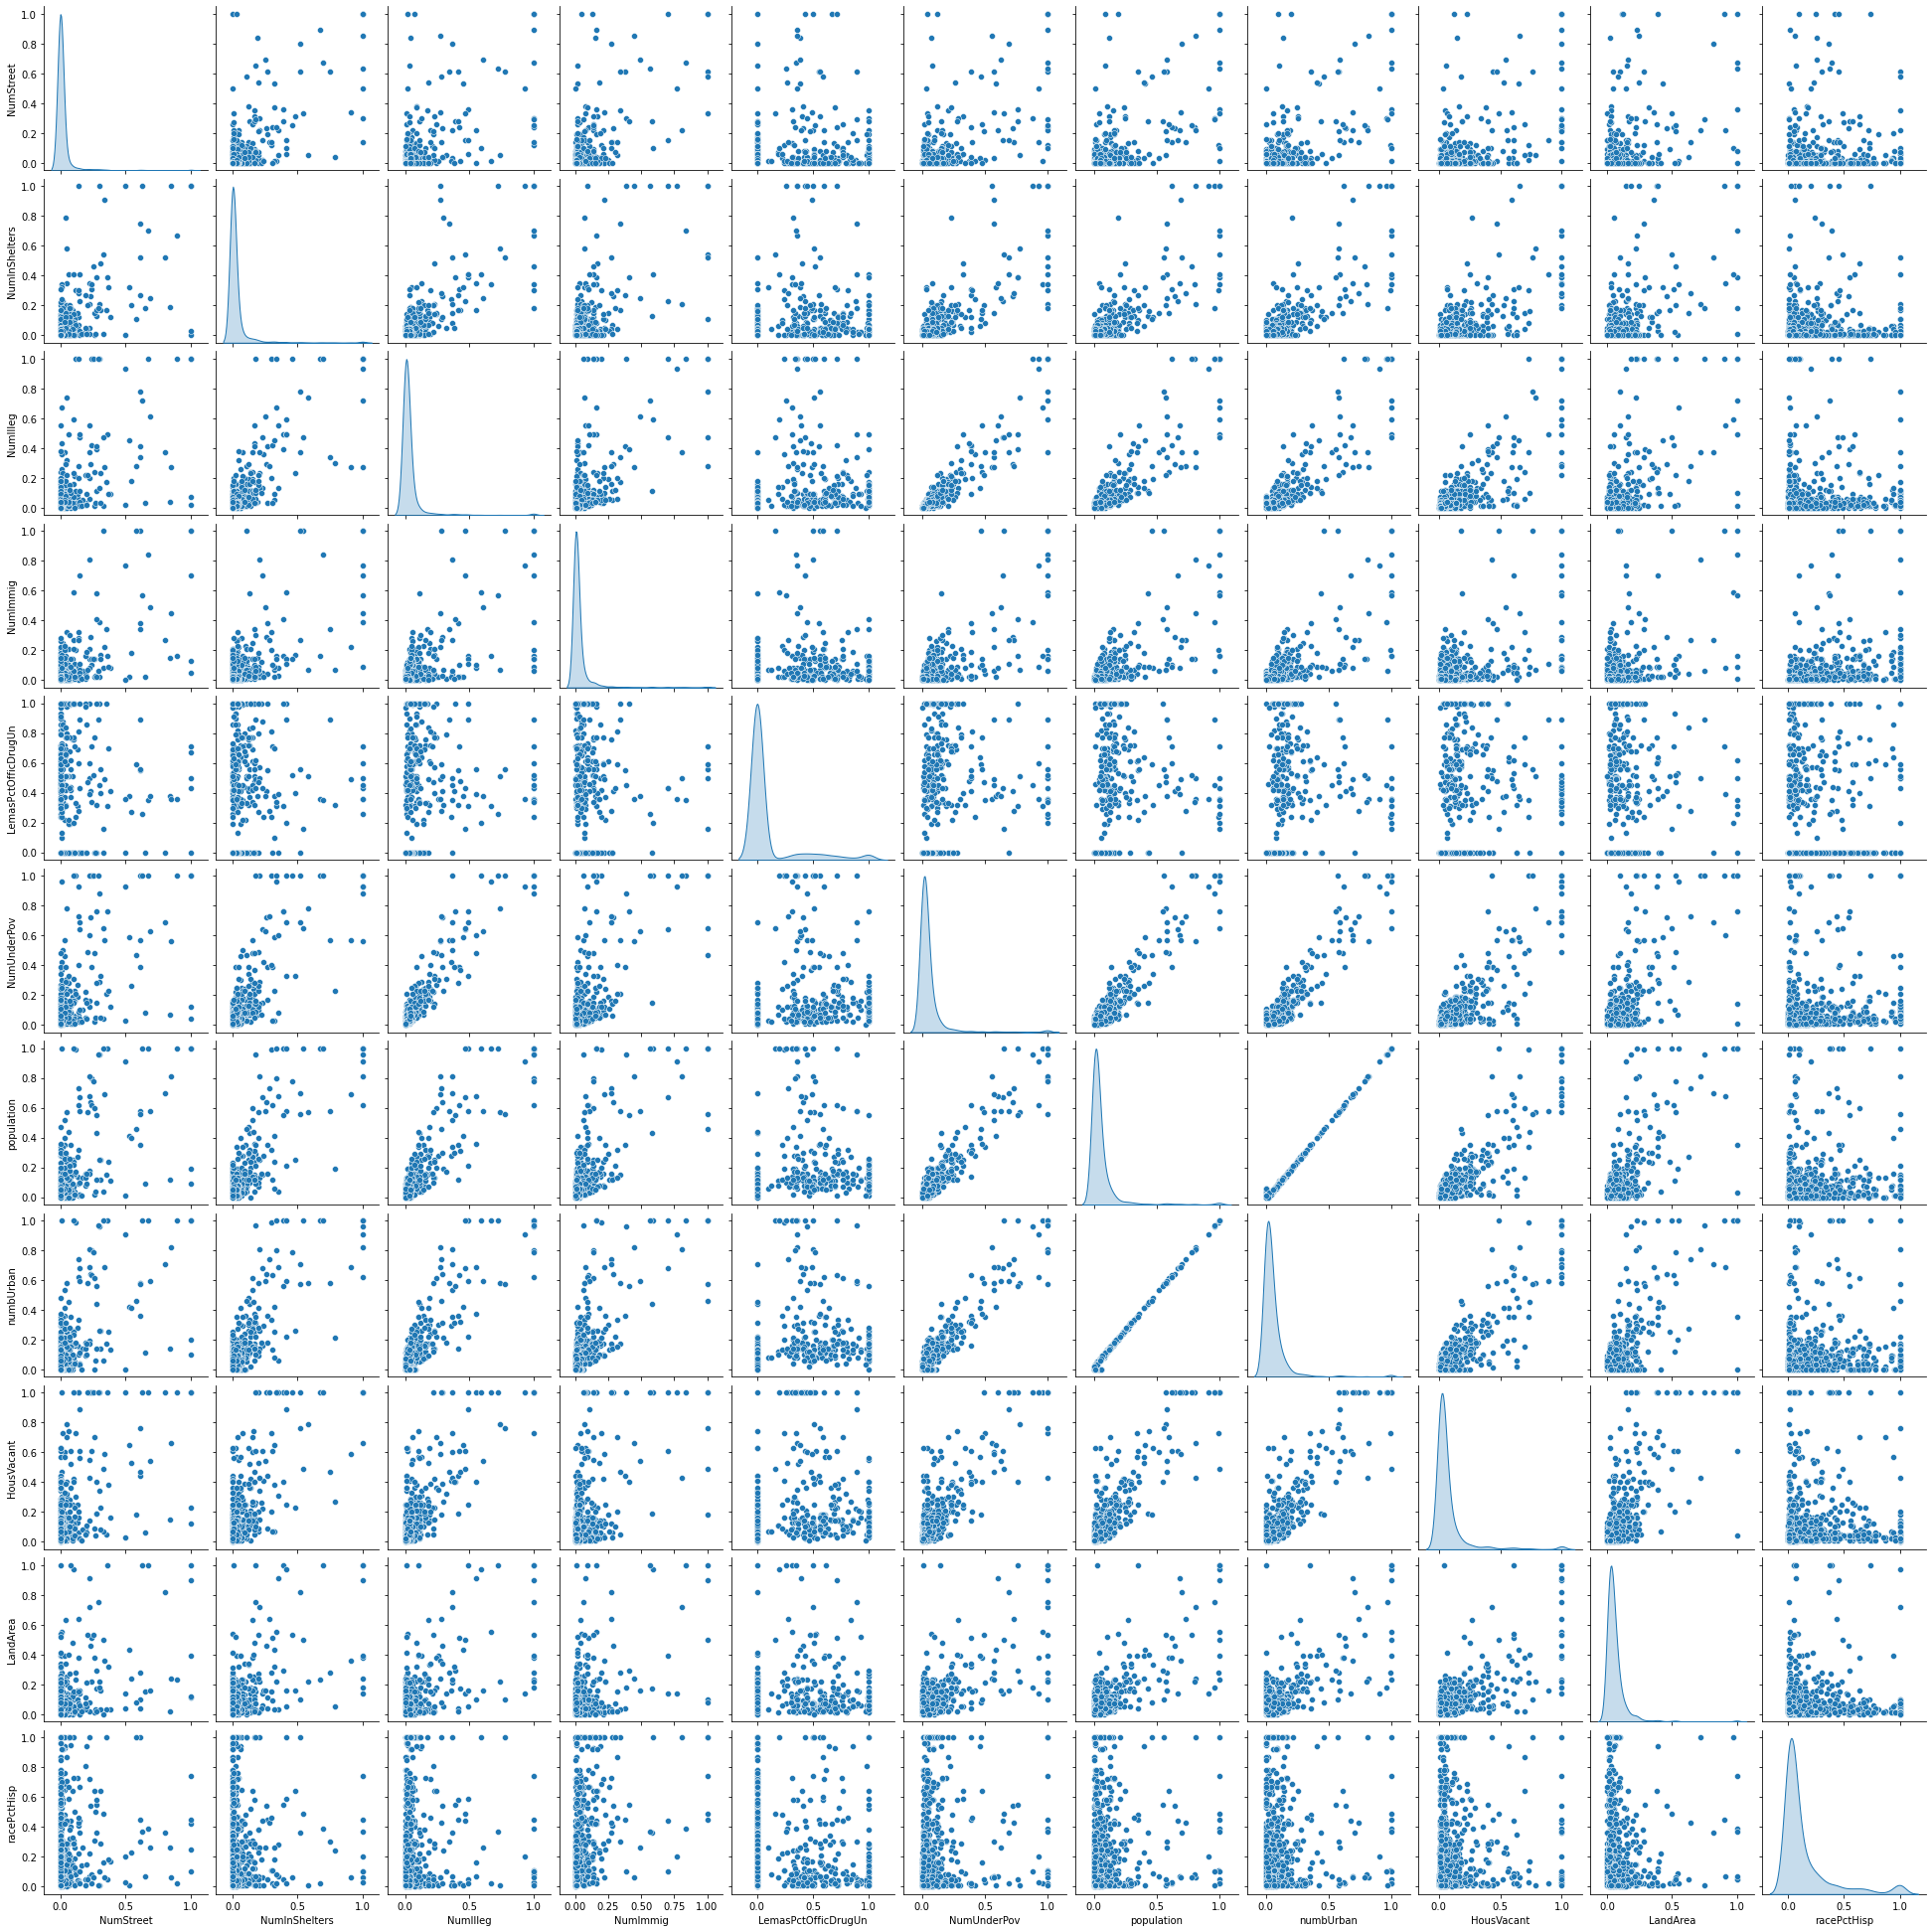

In [28]:
# Scatter Plots
sns.pairplot(top11CV_df,diag_kind='kde')
plt.show()

#### Key conclusions: 

By visual inspection:
1. The above set of plots show that there is a strong positive correlation between the columns 'population' (population of community) and 'numbUrban' (Urban population)
2. There is also weak positive correlation seen between the sets of columns 
    a. 'numbUrban' and 'NumbUnderPov'
    b. 'population' and 'NumbUnderPov'
    c. 'Numllleg' and 'NumbUnderPov'

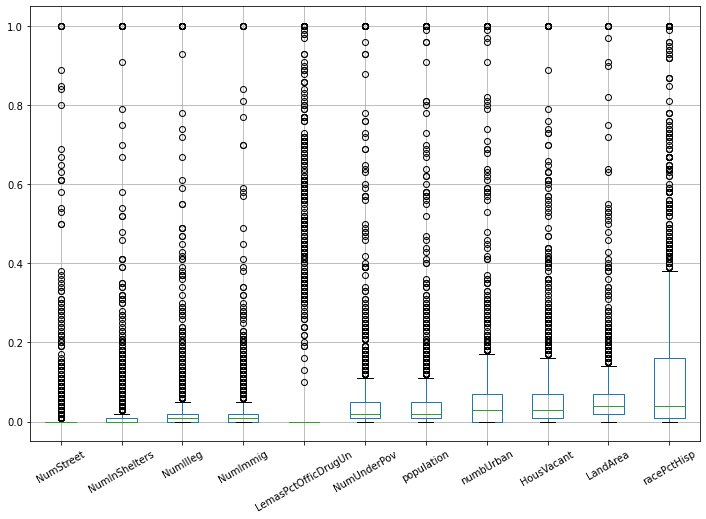

In [29]:
# Box Plots

plt.figsize=(14,10)
top11CV_df.boxplot(figsize=(12,8), rot=30, grid=True)
plt.show()

### f. Fit a linear model using least squares to the training set and report the test error.

In [30]:
linReg = LinearRegression()
linReg.fit(community_trainX,community_trainY)
community_predY = linReg.predict(community_testX)

lin_MSE = metrics.mean_squared_error(community_testY,community_predY)
print(f'The test mean square error (MSE) for Linear regression is {round(lin_MSE,4)}')

The test mean square error (MSE) for Linear regression is 0.7897


### g. Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [31]:
alphaList = 10**np.linspace(10,-2,100)*0.5

# obtaining ideal alpha performing 15 fold cross-validation
ridgeReg = RidgeCV(alphas=alphaList, cv = 15)
ridgeReg = ridgeReg.fit(community_trainX, community_trainY)

# Using ideal alpha from CV
ridgeRegModel = Ridge(alpha = ridgeReg.alpha_)
ridgeRegModel = ridgeRegModel.fit(community_trainX, community_trainY) 
community_predY_ridge = ridgeRegModel.predict(community_testX)

ridge_MSE = metrics.mean_squared_error(community_testY, community_predY_ridge)
print(f'The test mean square error (MSE) for Ridge regrssion is {round(ridge_MSE,4)}')

The test mean square error (MSE) for Ridge regrssion is 0.0176


### h. Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

#### NOTE: Since the data is already standardized, there is no need for normalization

In [32]:
# obtaining ideal alpha performing 15 fold cross-validation
lassoReg = LassoCV(alphas=alphaList, cv = 15)
lassoReg = lassoReg.fit(community_trainX, community_trainY) 

# Using ideal alpha from CV
lassoRegModel = Lasso(alpha=lassoReg.alpha_)
lassoRegModel = lassoRegModel.fit(community_trainX, community_trainY)
community_predY_lasso = lassoRegModel.predict(community_testX)

lasso_MSE = metrics.mean_squared_error(community_testY, community_predY_lasso)
print(f'The test mean square error (MSE) for Lasso regression is {round(lasso_MSE,4)}')

The test mean square error (MSE) for Lasso regression is 0.0188


In [33]:
# Features selected by the lasso regression model
feature_list = []
loc = 0

for i in lassoRegModel.coef_.tolist():
    if i != 0.0:
        feature_list.append(loc)
    loc+=1
    
colList = community_test.columns.tolist()

print('List of variables selected by the Lasso regression model are:')
list(community_test.iloc[:,feature_list].columns)

List of variables selected by the Lasso regression model are:


['racePctWhite',
 'pctUrban',
 'MalePctDivorce',
 'PctKids2Par',
 'PctIlleg',
 'PctPersDenseHous',
 'HousVacant',
 'PctVacantBoarded']

### i. Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [34]:
MSE_CV=[]

for i in list(range(1,123)):
    
    # Iterating thru 122 components with 15 fold CV for each
    pca = PCA(n_components=i, random_state=10)
    folds = KFold(n_splits=15, shuffle=True)
    
    # Fitting model
    PCAfit = pca.fit_transform(community_trainX)
    pca_mse = []
  
    for p,q in folds.split(PCAfit):
        
        PCA_trainX = PCAfit[p.tolist()]
        PCA_trainY = community_trainY[p.tolist()]
        
        topredX = PCAfit[q.tolist()]
        topredY = community_trainY[q.tolist()]
        
        pcaModel = LinearRegression()
        pcaModel = pcaModel.fit(PCA_trainX,PCA_trainY)
        community_predY_pca = pcaModel.predict(topredX)
        
        pca_mse.append(metrics.mean_squared_error(topredY, community_predY_pca))    
    MSE_CV.append(np.mean(pca_mse))

In [35]:
pd.set_option('display.max_rows', 130)
pca_mse_df = pd.DataFrame({"# Principal Components": list(range(1,123)), "Test Mean Square Error": MSE_CV})

print("Mean Square Error by # Principal Components:")
pca_mse_df

Mean Square Error by # Principal Components:


,# Principal Components,Test Mean Square Error
0,1,0.037980
1,2,0.030616
2,3,0.027719
3,4,0.024300
4,5,0.023145
5,6,0.022615
6,7,0.020043
7,8,0.020065
8,9,0.020062
9,10,0.019906


In [36]:
pd.set_option('display.max_rows', 10)

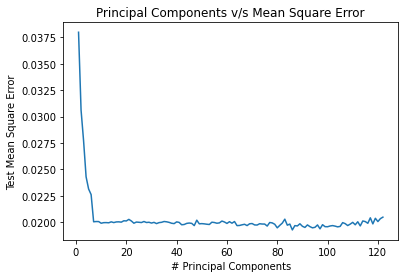

In [37]:
sns.lineplot(data=pca_mse_df, x="# Principal Components", y="Test Mean Square Error")
plt.title('Principal Components v/s Mean Square Error')
plt.show()

In [38]:
print(f'The test MSE drops significant until m=7 and flattens there after. Thus, ideal # principal components to choose would be 7 with an MSE of {round(pca_mse_df.iloc[6,1],4)}')

The test MSE drops significant until m=7 and flattens there after. Thus, ideal # principal components to choose would be 7 with an MSE of 0.02


### j. In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [40]:
# Gradient boost to select ideal alpha
xgbReg = XGBRegressor(objective='reg:squarederror')
Alpha_params = {'reg_alpha': alphaList}
xgb_CV = GridSearchCV(xgbReg, Alpha_params, cv=5)
xgb_CV = xgb_CV.fit(community_trainX, community_trainY)
idealAlpha_xgb = xgb_CV.best_params_['reg_alpha']

# Fit XGBoost for the ideal alpha
xgbModel = XGBRegressor(objective='reg:squarederror', reg_alpha=idealAlpha_xgb)
xgbModel = xgbModel.fit(community_trainX, community_trainY)

community_predY_xgb = xgbModel.predict(community_testX)
xgboostMSE = metrics.mean_squared_error(community_testY, community_predY_xgb)

In [41]:
print(f'The ideal alpha value obtained from cross validation is: {round(idealAlpha_xgb,2)}')
print(f'The associated mean square error is: {round(xgboostMSE,5)}')


The ideal alpha value obtained from cross validation is: 4.06
The associated mean square error is: 0.01796
